# K_Neghboors

## Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## K_means

### Centres initiallization

#### K_means++ initiallization

In [18]:
def k_means_plus_plus(elements, k = 2):
    #choosing a random array element as the 1st center
    new_start_ind = np.random.choice(np.arange(elements.shape[0]))
    centres = np.zeros((k, elements.shape[1]))
    centres[0] = np.array(elements[new_start_ind])
    for l in range(k-1):
        #norms array -- dx^2
        dif = np.zeros(elements.shape[0])
        for i in range(elements.shape[0]):
            dif[i] = np.linalg.norm(elements[i] - centres[0], ord = 2)
            j = l
            while j >= 0:
                dif[j] = min(np.linalg.norm(elements[i] - centres[j], ord = 2), dif[j])
                j = j - 1
        #summ of norms array -- S(dx^2)
        summ = np.sum(dif, axis = 0)
        #random element from [0, summ)
        rnd = np.random.random(size = 1) * summ
        #while temp_summ < summ: temp_sum += d(x_i)^2
        tmp = 0
        for i in range(elements.shape[0]):
            tmp = tmp + dif[i]
            #if temp_summ >= summ: next centre = elements[i]
            if tmp >= rnd:
                centres[l+1] = np.array(elements[i])
                break
    return centres

#### K_means initiallization

In [19]:
def k_means(elements, k = 2):
    #random elements from input array
    #choosing indexes
    mas = np.random.choice(elements.shape[0], size = k, replace = True)
    #choosing elements
    centres = np.zeros((k, elements.shape[1]))
    for i in range(k):
        centres[i] = np.array(elements[mas[i]])
    return centres

### Clustering function

In [36]:
def k_neigbs(elements, k = 5, plusplus = False):
    #initiallization
    if plusplus:
        centres = k_means_plus_plus(elements, k = k)
    else:
        centres = k_means(elements, k = k)
    #output clustering array
    clasts = np.zeros(elements.shape[0])
    #previous centres
    old_centres = np.array(centres)
    #flag -- if previous centres are equal to new
    flag = 1;
    while flag == 1:
        #clustering element
        for i in range(elements.shape[0]):
            #minimization of 2nd norm
            dif = np.linalg.norm(elements[i]-centres[0], ord = 2);
            min_ind = 0
            for j in range(k):
                tmpdif = np.linalg.norm(elements[i]-centres[j], ord = 2);
                if (tmpdif < dif):
                    min_ind = j
                    dif = tmpdif
            clasts[i] = min_ind
        #updating centres
        for i in range(k):
            counts = 0
            summ = np.zeros(elements.shape[1])
            for j in range(elements.shape[0]):
                if clasts[j] == i:
                    counts = counts + 1
                    summ += elements[j]
            #if there are no elements in this cluster don't upate center
            if (counts != 0):
                centres[i] = summ/counts
        if np.all(old_centres - centres) or elements.shape[0] <= k:
            flag = 0
        else:
            old_centres = np.array(centres)
    return clasts

### Plt visuallization

In [40]:
def clust(size, 
          scale = 1, 
          k = 5, 
          show = False, 
          int_type = False, 
          init_plus__plus = False):
    elements = np.zeros((size, 2))
    for i in range(size):
        if int_type:
            elements[i] = np.random.randint(low = 0, high = size, size = 2)
        else:
            elements[i] = np.random.random(size = 2)*scale
    clasts = k_neigbs(elements, k, plusplus = init_plus__plus)
    if show:
        plt.scatter(elements[:, 0], elements[:, 1], c=clasts)
        plt.show()
    return elements, clasts

## Samples

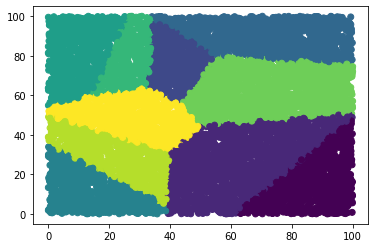

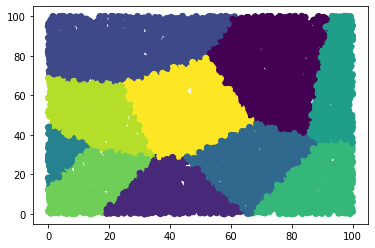

(array([[42.01375773, 87.49975453],
        [ 6.02449665, 15.51382863],
        [61.024524  , 82.68890018],
        ...,
        [28.36479584, 96.52420877],
        [47.10461895, 65.22564836],
        [51.64234696, 56.08985916]]),
 array([2., 7., 0., ..., 2., 9., 9.]))

In [41]:
clust(10000, 100, k = 10, show = True, init_plus__plus=True)
clust(10000, 100, k = 10, show = True)

### Time(num of elements)

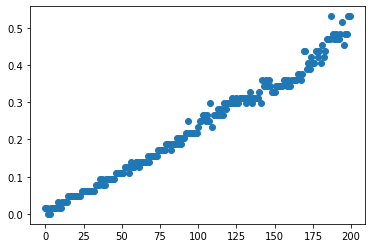

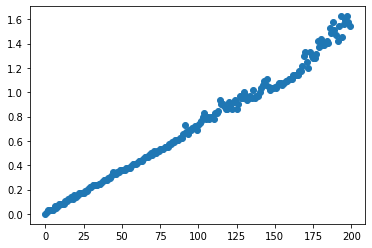

In [50]:
import time


times = np.zeros(200)

ntimes = np.zeros(200)

start = time.process_time()

for i in range(200):
    clust((i+1)*50, scale = (i+1)*50)
    times[i] = time.process_time() - start
    start = time.process_time()
    clust((i+1)*50, scale = (i+1)*50, init_plus__plus=True)
    ntimes[i] = time.process_time() - start
    start = time.process_time()

plt.scatter(np.arange(200), times)
plt.show()

plt.scatter(np.arange(200), ntimes)
plt.show()

In [74]:
import time

#go(400, 400, 19)
times = np.zeros(1000)

start = time.process_time()

i = 10
while i < 100:
    print(i)
    clust(2000, scale = 2000, k = i, init_plus__plus=True)
    times[i//10] = time.process_time() - start
    start = time.process_time()
    i += 10
    
plt.scatter(np.arange(1000), times)

#clust(200, scale = 200, k = 20, init_plus__plus=True)

10
20
30
40
50
60
70


KeyboardInterrupt: 

### Dist matrix

#### Elements & cluster

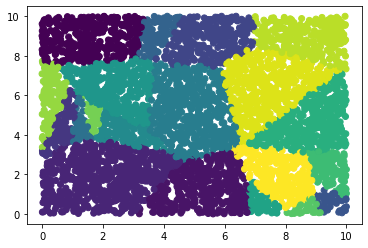

In [89]:
size = 5000
scale = 10
k = 20
els, clasts = clust(size, scale, k = k, show = True, init_plus__plus=True)

#### Matrix reallization

In [130]:
def dist_matrix(els, clasts, k):
    pos = np.zeros(k)

    newels = np.zeros((els.shape[0], 2))

    matrix = np.zeros((els.shape[0], els.shape[0]))

    for i in range(k):
        for j in range(els.shape[0]):
            if clasts[j] == i:
                newels[int(pos[i])] = np.array(els[j])
                pos[i] = pos[i] + 1
        if i < 9:
            pos[i+1] += pos[i]
            
    for i in range(newels.shape[0]):
        tmp = newels[i]
        for j in range(newels.shape[0]):
            matrix[i][j] = np.linalg.norm(newels[j]-tmp, ord = 2)
    return matrix

In [134]:
def default_dist_matrix(els):
    matrix = np.zeros((els.shape[0], els.shape[0]))
    
    for i in range(newels.shape[0]):
        tmp = els[i]
        for j in range(els.shape[0]):
            matrix[i][j] = np.linalg.norm(els[j]-tmp, ord = 2)
    return matrix

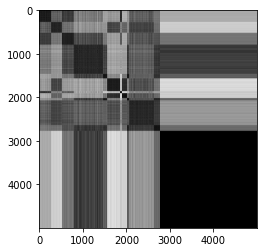

In [91]:
plt.imshow(dist_matrix(els, clasts, k), 'gray', interpolation=None)

In [124]:
def clust_P(size, 
          scale = 1, 
          k = 5, 
          show = False, 
          int_type = False, 
          init_plus__plus = False):
    elements = np.zeros((size, 2))
    for i in range(size):
        if int_type:
            elements[i] = np.random.randint(low = 0, high = size, size = 2)
        else:
            elements[i] = np.random.normal(size = 2)*scale
    clasts = k_neigbs(elements, k, plusplus = init_plus__plus)
    if show:
        plt.scatter(elements[:, 0], elements[:, 1], c=clasts)
        plt.show()
    return elements, clasts

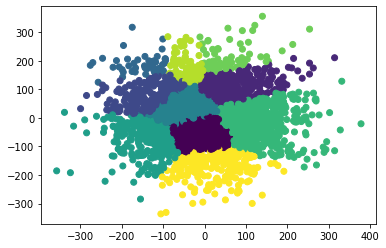

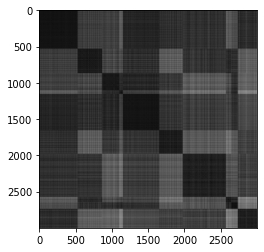

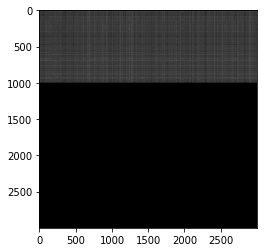

In [140]:
els, clasts = clust_P(3000, scale = 100, k = 10, show = True, init_plus__plus=True)
k = 10
plt.imshow(dist_matrix(els, clasts, k), 'gray', interpolation=None)
plt.show()

plt.imshow(default_dist_matrix(els), 'gray', interpolation=None)
plt.show()

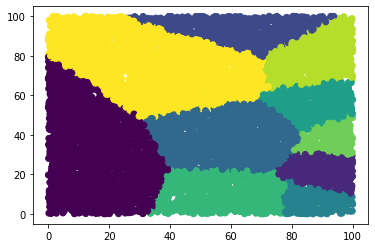

(array([[79.93385255, 39.30784247],
        [36.34332418, 51.0649097 ],
        [78.16680353, 67.3267338 ],
        ...,
        [46.60079492, 38.44840457],
        [95.27728314, 37.40957585],
        [ 6.14005563, 39.38825597]]),
 array([3., 9., 8., ..., 3., 7., 0.]))

In [127]:
clust(10000, scale = 100, k = 10, show = True, init_plus__plus=True)